## Price Per Square Foot Prediction
In this notebook I predict the price per square foot of a house in Nashville, using an XGBoost. 
Metrics used are root mean squared error, median absolute error, mean absolute error and coefficient of determination.

Since almost all numerical features of the dataset were heavily right-skewed, I have log-transformed every numerical feature except for the target variable (PPS).

I also ran a LightGBMRegressor which got almost identical results, but ran much faster.

### Observations

Quarter and Year are pretty essential variables but I wonder if there's a better way to incorporate time.


### Next step: incorporate data from historical sales.

### Consider adding average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
import prepper
# df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

nash = prepper.prep('joined_20190912140448.csv')

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,19,20,21,27,29,34,37,38,40,41,46,47,48,49,50,53,54,55,64) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
#Clearing out a few outliers.
#Removing massive parcels of land isn't so much about them being outliers; this model is for urban development.
print(nash['Fixtures'].quantile([.97,.985,.995]))
nash=nash[nash.Fixtures <=23]

print(nash['Land Area Acres'].quantile([.97,.985,.995]))
nash=nash[nash['Land Area Acres'] <=3]

#Giving PPS more leeway because it's our target variable (and it varies more)
print(nash['PPS'].quantile([.97,.985,.997]))
nash=nash[nash.PPS <= 700]

0.970    18.0
0.985    20.0
0.995    24.0
Name: Fixtures, dtype: float64
0.970    1.05
0.985    1.39
0.995    2.47
Name: Land Area Acres, dtype: float64
0.970    359.013406
0.985    434.322638
0.997    591.417031
Name: PPS, dtype: float64


## First, checking what the absolute smallest and largest PPS observations are.

In [4]:
nash.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
183495,690 CANDLESTICK DR,1.0,49.0,0.027313,1794.0,SINGLE FAM,Average
198474,5441 CAMELOT RD,2.0,10000.0,2.211411,4522.0,SINGLE FAM,Average
457402,1013 SUMMERCREST CT,8.0,10000.0,4.108463,2434.0,SINGLE FAM,Average
144369,64 VALERIA ST,1.0,5000.0,4.340278,1152.0,SINGLE FAM,Average
122359,31 N HILL ST,1.0,10001.0,4.857212,2059.0,SINGLE FAM,Average


In [5]:
nash.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
530625,6264.0,752.879821
530596,6264.0,752.879821
530653,6264.0,752.879821
530611,6264.0,752.879821
530651,6264.0,752.879821


## Next, checking the distribution of several numerical features.
I'll end up log-transforming all of these.
'Fixtures' doesn't appear skewed, but the model performs slightly better when it's transformed.

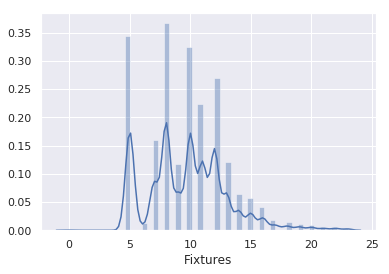

In [6]:
sns.distplot(nash['Fixtures'].dropna())

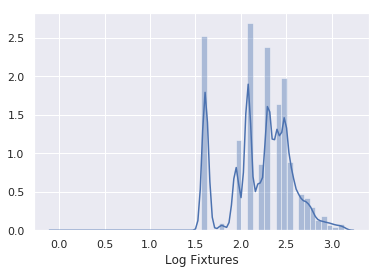

In [7]:
#Not very different, but the model performs slightly better when it's transformed
sns.distplot(nash['Log Fixtures'].dropna())

In [8]:
nash.nlargest(10, 'Land Area Acres')

,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,Building Grade2,...,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land,Log NbhdPPS,Log NbhdRatio,Log Built
13282,"$44,250","$20,250","$64,500",2019.0,3.0,NaN,Fair,NaN,C,NaN,...,2,2015,9.915910,2.397895,7.888335,4.540882,1.098612,4.772120,-2.603969,6.861616
215263,"$41,100","$31,250","$72,350",2019.0,2.0,NaN,Average,NaN,C,NaN,...,3,2015,10.349775,2.079442,7.604396,5.130915,1.098612,4.934089,-2.912313,7.226057
215260,"$45,450","$31,250","$76,700",2019.0,2.0,NaN,Average,NaN,C,NaN,...,3,2016,10.349775,2.079442,7.893572,4.567143,1.098612,4.934089,-2.912313,7.226057
108181,"$91,950","$20,000","$111,950",2019.0,3.0,NaN,Average,NaN,B,NaN,...,3,2016,9.903488,2.397895,8.193400,4.482676,1.098612,4.767184,-2.816275,7.966975
215261,"$63,150","$31,250","$94,400",2019.0,4.0,NaN,Average,NaN,C,NaN,...,4,2016,10.349775,2.484907,7.813996,5.157545,1.098612,4.934089,-2.912313,7.156288
165924,"$39,775","$18,000","$57,775",2019.0,1.0,NaN,Average,NaN,C,NaN,...,4,2016,9.798127,1.945910,7.712444,4.675950,1.098612,4.820341,-2.887247,7.491470
150246,"$95,200","$29,000","$124,200",2019.0,3.0,NaN,Average,NaN,B,NaN,...,4,2016,10.275051,2.397895,8.311890,4.800423,1.098612,5.075999,-2.605345,7.491470
84999,"$78,000","$131,720","$209,720",2019.0,3.0,NaN,Average,NaN,C,NaN,...,1,2017,11.788434,2.564949,8.050384,4.512488,1.098612,4.512488,-1.381386,7.677665
169706,"$139,550","$29,000","$168,550",2019.0,4.0,NaN,Average,NaN,B,NaN,...,2,2017,10.275051,2.833213,8.429891,5.010926,1.098612,5.075999,-2.605345,5.312253
22761,"$21,875","$12,000","$33,875",2019.0,1.0,NaN,Average,NaN,C,NaN,...,2,2017,9.392662,1.609438,7.259116,4.754585,1.098612,4.646261,-2.130727,8.334916


## Now to the Machine Learning:

First I'll run a dummy regressor, which just guesses the median. Then I'll attempt a few different models with increasing accuracy.

In [9]:
#Important metric to keep in mind when judging your model's performance.
np.std(nash.PPS)

78.425955954947

In [90]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

ML = nash[['Neighborhood','Log Built','Log NbhdRatio','Building Condition',
           'Log SqFt','Log Fixtures','Building Type Custom','Building Grade',
           'Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 
           'Year Built', 'Zone']].dropna()

#dtreeviz doesn't work with features whose names have spaces.
ML.columns = ['Neighborhood', 'Log-Built','Log-NbhdRatio', 'Building-Condition', 
              'Log-SqFt', 'Log-Fixtures', 'Building-Type-Custom', 'Building-Grade', 
              'Exterior-Wall', 'Year', 'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 
              'Year-Built', 'Zone']

print(nash.shape)
print(ML.shape)

X= pd.get_dummies(ML[['Log-Built','Log-NbhdPPS','Log-SqFt','Year','Log-Fixtures', 
                      'Quarter', 'Building-Grade', 'Building-Type-Custom', 
                      'Neighborhood']])
y=ML['PPS']

(53726, 81)
(53650, 16)


In [91]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']


In [92]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'CV score of {score} is {scores[score].mean()}')

CV score of fit_time is 0.04188861846923828
CV score of score_time is 0.0026961326599121093
CV score of test_r2 is -0.26041083687323474
CV score of test_neg_mean_absolute_error is -56.52181754932493
CV score of test_neg_median_absolute_error is -36.186639233183236
CV score of test_neg_mean_squared_error is -7132.377719120368
CV score of test_neg_mean_squared_log_error is -0.20807602669734693


In [93]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'CV score of {score} is {scores[score].mean()}')

CV score of fit_time is 0.8053337574005127
CV score of score_time is 0.17304635047912598
CV score of test_r2 is 0.6013297209286099
CV score of test_neg_mean_absolute_error is -31.00779577721594
CV score of test_neg_median_absolute_error is -18.603851875039037
CV score of test_neg_mean_squared_error is -2258.792365130168
CV score of test_neg_mean_squared_log_error is -0.1656980545918279


In [94]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 
           'neg_mean_squared_error', 'neg_mean_squared_log_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, 
                        scoring=scoring, return_train_score=False)
for score in scores:
    print(f'CV score of {score} is {scores[score].mean()}')

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CV score of fit_time is 4.98642201423645
CV score of score_time is 0.29878721237182615
CV score of test_r2 is 0.7162208467848398
CV score of test_neg_mean_absolute_error is -26.19937459211031
CV score of test_neg_median_absolute_error is -16.078537095027784
CV score of test_neg_mean_squared_error is -1612.784503401032
CV score of test_neg_mean_squared_log_error is -0.09316363535465984


In [95]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

model.fit(X_train,y_train)
y_predxg=model.predict(X_test)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_median_absolute_error', 'neg_mean_squared_error']
scores = cross_validate(model, X_train, y_train, cv=tscv, scoring=scoring, return_train_score=False)
for score in scores:
    print(f'CV score of {score} is {scores[score].mean()}')

/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show()

### Now testing Microsoft's LightGBM

LightGBM runs much faster (which gives me more time for tuning) and includes some built-in graphing abilities. Performance is generally about the same, but sometimes better than XGBoost, depending on the dataset.

/home/drew/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's l1: 18.7909	valid_1's l1: 26.427
[200]	training's l1: 18.0972	valid_1's l1: 26.0143
[300]	training's l1: 17.6766	valid_1's l1: 25.8069
[400]	training's l1: 17.3287	valid_1's l1: 25.6874
[500]	training's l1: 17.0686	valid_1's l1: 25.594
[600]	training's l1: 16.8449	valid_1's l1: 25.5178
[700]	training's l1: 16.6352	valid_1's l1: 25.483
[800]	training's l1: 16.4942	valid_1's l1: 25.4633
[900]	training's l1: 16.3277	valid_1's l1: 25.4258
[1000]	training's l1: 16.1517	valid_1's l1: 25.3719
RMSE: 41.76865607457278
Median Absolute Error: 14.506270992898294
Mean Absolute Error: 25.371861564071853
Coefficient of Determination: 0.7356535510566974
Root Mean Squared Logarithmic Error: 0.2713051416001116


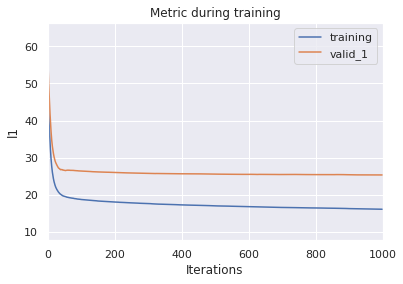

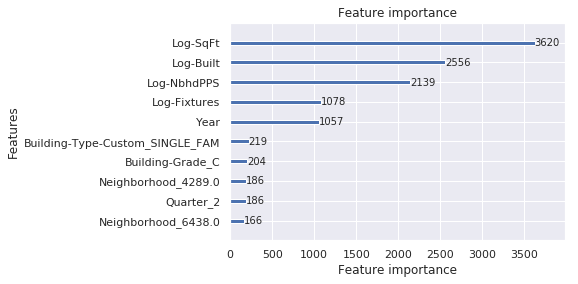

In [96]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test,y_test)
evals_result={}
params = {'objective':'regression_l1', 'max_depth': 6,'reg_alpha':2, 'metric':'l1', 
          'min_child_weight': 40, 'n_estimators': 1000, 'num_leaves': 250}
gbm = lgb.train(params=params,
                train_set= dtrain,
                valid_sets=[dtrain, dvalid],
                evals_result=evals_result,
                verbose_eval=100)
y_predgbm=gbm.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predgbm)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predgbm)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predgbm)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predgbm)))
print('Root Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predgbm),np.abs(y_test))**0.5))
lgb.plot_metric(booster=evals_result)
lgb.plot_importance(gbm, max_num_features=10)

In [70]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()
evals_result={}
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [500],
    'min_child_weight':[30,50],
    'max_depth': [5],
    'num_leaves': [350]
    }
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_predlgb= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_test,y_predlgb)**0.5)
print(MAE(y_test,y_predlgb))
print(mean_absolute_error(y_test, y_predlgb))
print(r2_score(y_test, y_predlgb))

Best parameters found by grid search are: {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 500, 'num_leaves': 350}
-979.7414304038286
40.70816450542394
13.789789824617856
24.68290634952489
0.7489064720251355


In [ ]:
gbm.best_estimator_

In [97]:
# save model to file
gbm.save_model('model.txt')
# dump model to JSON (and save to file)
model_json = gbm.dump_model()

Dumping model to JSON...


## Examining residual errors

In [ ]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

In [ ]:
plt.figure(figsize=(9,9))
plt.title('Residuals from XGBoost Model',fontsize=20)
sns.distplot(copiedxg.Residual.dropna())

In [ ]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the actual PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(15,'Residual')[['Log-NbhdPPS', 'Actual', 'Predicted', 'Residual']]

In [ ]:
copiedxg.nlargest(15, 'Residual')[['Actual','Predicted','Residual', 'Log-NbhdPPS']]

In [ ]:
copiedlgb= X_test.copy()
copiedlgb['Actual']= y_test
copiedlgb['Predicted']= y_predgbm
copiedlgb['Residual'] = np.absolute(copiedlgb['Actual'] - copiedlgb['Predicted'])
copiedlgb.nlargest(15, 'Residual')

In [ ]:
plt.figure(figsize=(9,9))
plt.title('Residuals from LightGBM Model',fontsize=20)
sns.distplot(copiedlgb.Residual.dropna())

## Interpretting the Model

In [ ]:
import statsmodels as sm
lowess = sm.nonparametric.smoothers_lowess.lowess
z = lowess(y_predgbm, y_test)
test = pd.DataFrame({"prediction": copiedlgb['Predicted'], "observed": copiedlgb['Actual']})
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("LightGBM: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted PPS", fontsize = 18) 
plt.ylabel("Observed PPS", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x =copiedlgb['Actual']
y =copiedlgb['Residual']
z =copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x))
plt.title('LightGBM Model', fontsize=18)
ax.scatter(x, y, z, c='g', marker='o')
ax.set_xlabel('X: PPS')
ax.set_ylabel('Y: Residual')
ax.set_zlabel('Z: Neighborhood PPS')

#It looks like the biggest residuals are for houses where the actual PPS was very different from the average PPS in the neighborhood.
#To clarify: these observations are up (high Neighborhood PPS), to the left (low PPS), and back (high residual error)

In [ ]:
diff = np.abs(copiedlgb['Actual']-copiedlgb['Log-NbhdPPS'].map(lambda x: np.exp(x)))
plt.figure(figsize=(9,9))
plt.scatter(diff,copiedlgb['Residual'])
plt.xlabel('Difference between House PPS and Nbhd Avg PPS', fontsize=13)
plt.ylabel('Residual', fontsize=13)
plt.title('LightGBM Model', fontsize=20)
#So the residual is linearly correlated with how different the house's PPS is from the average PPS in its neighborhood.
#However, NeighborhoodPPS is an important feature in the ML model and performance suffers without it
#To me, this means the NeighborhoodPPS is a good start for a metric, but can be improved (with historical sales data)
#In my next iteration of the model, I'll put in more info about sales in each neighborhood.

## Model Interpretation with SHAP
Features in red pushed the prediction higher, features in blue pushed it lower. 
SHAP visualizes with D3 and GitHub doesn't display JavaScript so I won't add any SHAP plots past these 2 for now.

## Visualize the feature effects for the 200th prediction (chosen as a random example)
## Features in red pushed the prediction higher, blue features pushed it lower.

![title](shap.png)